Project 1

Sabrina Pereira

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

I set out to explore how the opiod epidemic has affected the life expectancy in the US, using age-adjusted death rates.

First, let us load the data. I will also add the life expectancies the CDC has released in recent years that were not included in the dataset. These can be found at the following links:

Mortality in the United States, 2015: https://www.cdc.gov/nchs/products/databriefs/db267.htm

Mortality in the United States, 2016: https://www.cdc.gov/nchs/products/databriefs/db293.htm

Mortality in the United States, 2017: https://www.cdc.gov/nchs/products/databriefs/db328.htm

In [2]:
nchs = pd.read_csv('nchs.csv', sep=',')
opioid = pd.read_csv('Opiod Related Deaths, 1999-2017.txt', sep='\t')
mortality = pd.read_csv('All Deaths, 1999-2017.txt', sep='\t')

#Extract total deaths
opioid_totals = opioid[(opioid.Notes == 'Total') & (opioid.Year.notna())].reset_index(drop=True)
mortality_totals = mortality[(mortality.Notes == 'Total') & (mortality.Year.notna())].reset_index(drop=True)

#Clean data to only contain rows that have valid years
opioid = opioid[(opioid.Year.notna()) & (opioid['Ten-Year Age Groups Code'] != 'NS') & (opioid.Notes.isna())]
mortality = mortality[(mortality.Year.notna()) & (mortality['Ten-Year Age Groups Code'] != 'NS') & (mortality.Notes.isna())]


d = {'Year': [2017, 2016, 2015], 'Race': 3*['All Races'], 'Sex' : 3*['Both Sexes'], 'Average Life Expectancy (Years)':[78.6,78.7, 78.7], 'Age-adjusted Death Rate': [731.9, 728.8, 733.1]}
df = pd.DataFrame(data=d)

#Adding the nchs data to a data frame with the most recent data 
nchs = df.append(nchs.drop([0]), ignore_index=True)

mortality

,Notes,Year,Year Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate
0,NaN,1999.0,1999.0,< 1 year,1,27937.0,3795762,736.0
1,NaN,1999.0,1999.0,1-4 years,1-4,5249.0,15339782,34.2
2,NaN,1999.0,1999.0,5-14 years,5-14,7595.0,40819824,18.6
3,NaN,1999.0,1999.0,15-24 years,15-24,30656.0,38676031,79.3
4,NaN,1999.0,1999.0,25-34 years,25-34,41066.0,40178406,102.2
5,NaN,1999.0,1999.0,35-44 years,35-44,89256.0,45076677,198.0
6,NaN,1999.0,1999.0,45-54 years,45-54,152974.0,36577819,418.2
7,NaN,1999.0,1999.0,55-64 years,55-64,238979.0,23778026,1005.0
8,NaN,1999.0,1999.0,65-74 years,65-74,452600.0,18418909,2457.3
9,NaN,1999.0,1999.0,75-84 years,75-84,698590.0,12224914,5714.5


In [3]:
nchs.head()

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
0,2017,All Races,Both Sexes,78.6,731.9
1,2016,All Races,Both Sexes,78.7,728.8
2,2015,All Races,Both Sexes,78.7,733.1
3,2014,All Races,Both Sexes,78.9,724.6
4,2013,All Races,Both Sexes,78.8,731.9


We are interested in the population as a whole, so we will take only the parts of the NCHS data that describe everyone.  

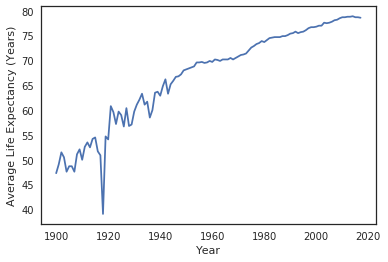

In [4]:
everyone = nchs[(nchs.Race == 'All Races') & (nchs.Sex == 'Both Sexes')]

plt.plot(everyone.Year, everyone['Average Life Expectancy (Years)'])

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)');

We are only interested in the data of recent years, so we will put the data from 1999-2017 in a new data frame to align with our mortality data. We will also make sure that this data frame has the years in acscending order to match the mortality data.

In [5]:
recent = everyone[everyone.Year > 1998][::-1].reset_index(drop=True)
recent.head()

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
0,1999,All Races,Both Sexes,76.7,875.6
1,2000,All Races,Both Sexes,76.8,869.0
2,2001,All Races,Both Sexes,77.0,858.8
3,2002,All Races,Both Sexes,77.0,855.9
4,2003,All Races,Both Sexes,77.6,843.5


Let's take a closer look at how life expectancy in the US has changed in the recent years.

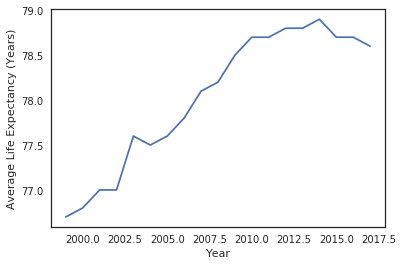

In [6]:
plt.plot(recent.Year, recent['Average Life Expectancy (Years)'])
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)');

Lets take a look at how opiod overdose related deaths have changed over the same interval. In order to adjust for population, we will use the crude rate instead of number of deaths - this indicates deaths per 100,000 people.

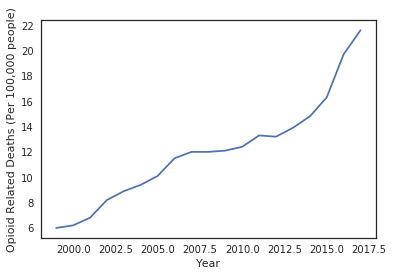

In [7]:
plt.plot(opioid_totals.Year, opioid_totals['Crude Rate'].astype('float64'))
plt.xlabel('Year')
plt.ylabel('Opioid Related Deaths (Per 100,000 people)');

It seems that around 2015, at the same time we start noticing that the number of opiod overdose releated deaths starts dramatically increasing, the life expectancy starts to drop.

If the increase in opiod related deaths has impacted the life expectancy negatively, we would expect to see that there is a negative relationship between the two variables.

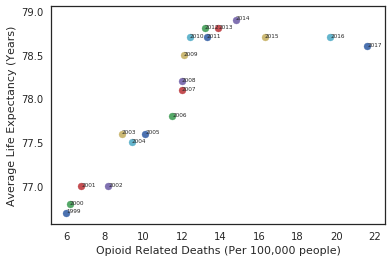

In [8]:
for i, txt in enumerate(recent.Year):
    plt.scatter(opioid_totals['Crude Rate'].astype('float64')[i],recent['Average Life Expectancy (Years)'][i])
    plt.annotate(txt, (opioid_totals['Crude Rate'].astype('float64')[i],recent['Average Life Expectancy (Years)'][i]), fontsize = 'xx-small')


plt.xlabel('Opioid Related Deaths (Per 100,000 people)')
plt.ylabel('Average Life Expectancy (Years)');



Unfortunately, there seems to be a very positive relationship between opioid related deaths and average life expectancy in the very beginning. The deaths related to opioid overdoses cannot be contriuting to this rising life expectancy - this is more likely due to other factors such as improvements in healthcare and sanitation. 

Recalcultating the theoretical life expectancies removing the effect of the opioid related deaths to observe how much of the drop in life expectancy is explained by the opiod related deaths would be ideal, but it was a bit out of scope for this project (could likely be done in a continuation of the project).

For simplifications, I will then be looking at how the Age-adjusted death rate would change, as I suspect that the variables are closely related.

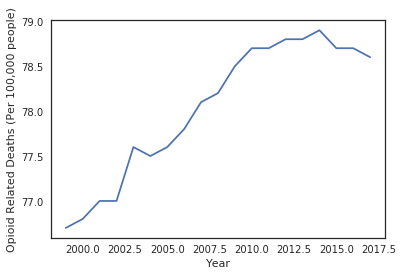

In [9]:
plt.plot(recent.Year, recent['Average Life Expectancy (Years)']);
plt.xlabel('Year')
plt.ylabel('Opioid Related Deaths (Per 100,000 people)');

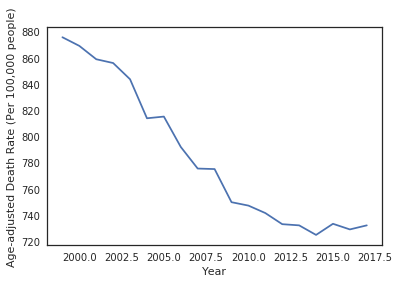

In [10]:
plt.plot(recent.Year, recent['Age-adjusted Death Rate']);
plt.xlabel('Year')
plt.ylabel('Age-adjusted Death Rate (Per 100,000 people)');

The two graphs seem quite similar, so I performed a linear regression to see how strong the correlation is between the two variables. The coefficient of determination is .97, indicating that by knowing what happens to the age-adjusted death rate we know much about what is going on with the average life expectancy.

0.9742939852917004


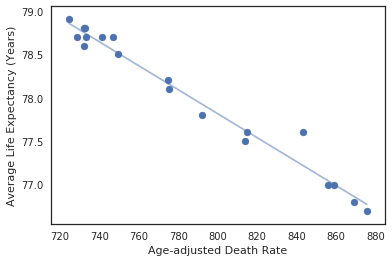

In [25]:
from scipy.stats import linregress

xs = recent['Age-adjusted Death Rate']
ys = recent['Average Life Expectancy (Years)']

res = linregress(xs, ys)

fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)



plt.scatter(recent['Age-adjusted Death Rate'], recent['Average Life Expectancy (Years)']);
plt.xlabel('Age-adjusted Death Rate')
plt.ylabel('Average Life Expectancy (Years)')
print(res.rvalue**2)

Since we have the data for the total population and number of deathf for each year, it should be simple to calculate the Death Rates for each year.

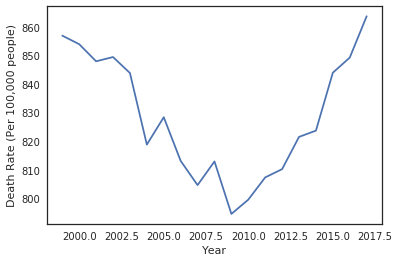

In [12]:
plt.plot(mortality_totals.Year, mortality_totals['Crude Rate'].astype('float64'))

plt.xlabel('Year')
plt.ylabel('Death Rate (Per 100,000 people)');

This graph looks very different from the Age-Adjusted Death Rates graph we got using the NCHS data - this is because we need to take into account that some years will have more people in an age group that are likely to die, driving the death rates up (for example, a larger older population). 

To calculate the Age-Adjusted Death Rates with our data, we need to identify a "Standard Population". Age-adjusted rates are the Death Rates that you would observe if the the population in a different year had the same population distribution as the Standard Population. 

The National Center for Health Statistics uses the year 2000 for the Standard Population, so it is what I will be using as well.

Below is a function I will be using to generate the appropriate proportion of the population for each age group using the U.S. 2000 population distribution.

In [13]:
def age_group_pop_prop(row, year):
    """    
    Takes in a row from a DataFrame and the desired year for the Standard Population.
    Reads the Age Group from the row, and returns the correct Standard Proportion.
    
    """  
    adjustment_mapping = {}
    standard_pop = float(mortality_totals[(mortality_totals.Year == 2000)].Population)

    for i, rows in mortality[mortality.Year == 2000].iterrows():
        adjustment_mapping[rows['Ten-Year Age Groups Code']] = float(rows['Population'])/standard_pop
    return adjustment_mapping.get(row['Ten-Year Age Groups Code'])

I will be adding a column for the Standard Proportion to the mortality DataFrame in order to use it to later find the Age-Adjusted Death Rates.

In [14]:
mortality['Standard Proportion'] =  mortality.apply(lambda row: age_group_pop_prop(row, 2000), axis=1)
mortality.head()

,Notes,Year,Year Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate,Standard Proportion
0,NaN,1999.0,1999.0,< 1 year,1,27937.0,3795762,736.0,0.013523
1,NaN,1999.0,1999.0,1-4 years,1-4,5249.0,15339782,34.2,0.054616
2,NaN,1999.0,1999.0,5-14 years,5-14,7595.0,40819824,18.6,0.145964
3,NaN,1999.0,1999.0,15-24 years,15-24,30656.0,38676031,79.3,0.139235
4,NaN,1999.0,1999.0,25-34 years,25-34,41066.0,40178406,102.2,0.141751


Using the Age-Adjusted Death Rate Definition from the Missouri Department of Health and Senior Services (https://health.mo.gov/data/mica/CDP_MICA/AARate.html), 

AADR = Summation of (ASDR X standard proportion) 
  
Where ASDR (Age-Specific Death Rate) = deaths in age group ÷ estimated population of that age group × 100,000, equivalent to the information held in the Crude Rate Column.

I will multiply the `Crude Rate` and the `Standard Proportion` columns in order to find the proportion of each Crude Rate to sum for the year's Age-Adjusted Death Rate.

In [15]:
mortality['CR*SP'] =  mortality['Crude Rate'].astype('float64')*mortality['Standard Proportion']
mortality.head()

,Notes,Year,Year Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate,Standard Proportion,CR*SP
0,NaN,1999.0,1999.0,< 1 year,1,27937.0,3795762,736.0,0.013523,9.952875
1,NaN,1999.0,1999.0,1-4 years,1-4,5249.0,15339782,34.2,0.054616,1.867869
2,NaN,1999.0,1999.0,5-14 years,5-14,7595.0,40819824,18.6,0.145964,2.714938
3,NaN,1999.0,1999.0,15-24 years,15-24,30656.0,38676031,79.3,0.139235,11.041367
4,NaN,1999.0,1999.0,25-34 years,25-34,41066.0,40178406,102.2,0.141751,14.486911


I will now add sum the values for each year's Age-Adjusted Death Rate, and add it as a column to `mortality_totals`. 

In [16]:

def calculate_AADR(row, df):
    """
    Takes in an input row from a DataFrame of totals.
    Returns the Age-Adjusted Death Rate.
    """
    year = row.Year
    AADR = df[df.Year == year]['CR*SP'].sum()
    
    return AADR
    
       
mortality_totals['Age-adjusted Death Rate'] = mortality_totals.apply(lambda row: calculate_AADR(row, mortality), axis=1)    
mortality_totals.head()


,Notes,Year,Year Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate,Age-adjusted Death Rate
0,Total,1999.0,1999.0,NaN,NaN,2391399.0,279040168,857.0,860.425108
1,Total,2000.0,2000.0,NaN,NaN,2403351.0,281421906,854.0,853.883170
2,Total,2001.0,2001.0,NaN,NaN,2416425.0,284968955,848.0,843.925198
3,Total,2002.0,2002.0,NaN,NaN,2443387.0,287625193,849.5,840.992571
4,Total,2003.0,2003.0,NaN,NaN,2448288.0,290107933,843.9,828.798343


My calculalted Age Adjusted Death Rates closely match the trend of those in the NCHS dataset. The difference may be due to differences in the 

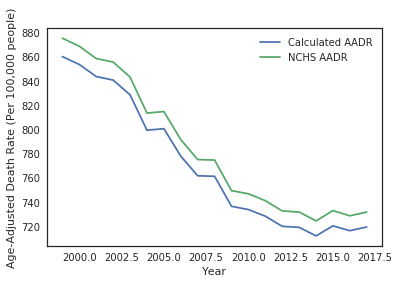

In [17]:
plt.plot(mortality_totals.Year, mortality_totals['Age-adjusted Death Rate'], label = 'Calculated AADR')
plt.plot(recent.Year, recent['Age-adjusted Death Rate'], label = 'NCHS AADR');

plt.xlabel('Year')
plt.ylabel('Age-Adjusted Death Rate (Per 100,000 people)');
plt.legend()

0.9746100048542374


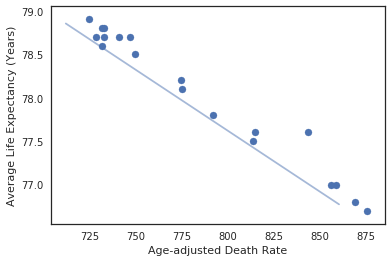

In [24]:
xs = mortality_totals['Age-adjusted Death Rate']
ys = recent['Average Life Expectancy (Years)']

res = linregress(xs, ys)

fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)



plt.scatter(recent['Age-adjusted Death Rate'], recent['Average Life Expectancy (Years)']);
plt.xlabel('Age-adjusted Death Rate')
plt.ylabel('Average Life Expectancy (Years)')
print(res.rvalue**2)